# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

P.S. Some of the Parametrics and data structure are inspired by Eddie Forson's article here: https://towardsdatascience.com/teaching-cars-to-see-advanced-lane-detection-using-computer-vision-87a01de0424f


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob # For reading images from calibration floder
import math
%matplotlib inline

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

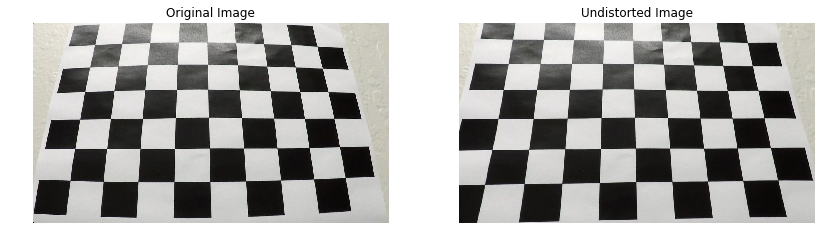

In [2]:
def load_obj_img_pts(cali_path="camera_cal/*.jpg", nx=9, ny=6, test=False):
    imgs_paths = glob.glob(cali_path)
    img = mpimg.imread(imgs_paths[0])
    objpts = []
    imgpts = []
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = mpimg.imread(img_path)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # If found
        if ret == True:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img.shape[1::-1], None, None)
    if test:
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        ax[0].imshow(img)
        ax[0].axis("off")
        ax[0].set_title("Original Image")
        ax[1].imshow(dst)
        ax[1].axis("off")
        ax[1].set_title("Undistorted Image")
        plt.show()
    return mtx, dist

mtx, dist = load_obj_img_pts("camera_cal/*.jpg", 9, 6, True)

## Apply a distortion correction to raw images

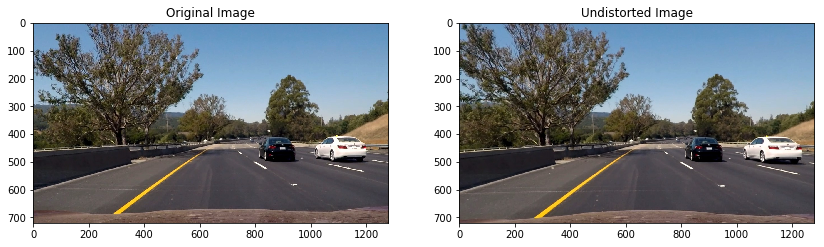

In [3]:
def undistort(img, mtx, dist, test=False):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    if test:
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        ax[0].imshow(img)
        ax[0].set_title("Original Image")
        ax[1].imshow(undist_img)
        ax[1].set_title("Undistorted Image")
        plt.show()
    return undist_img

#undist_img = undistort(mpimg.imread("camera_cal/calibration1.jpg"), mtx, dist, True)
undist_img = undistort(mpimg.imread("test_images/test6.jpg"), mtx, dist, True)

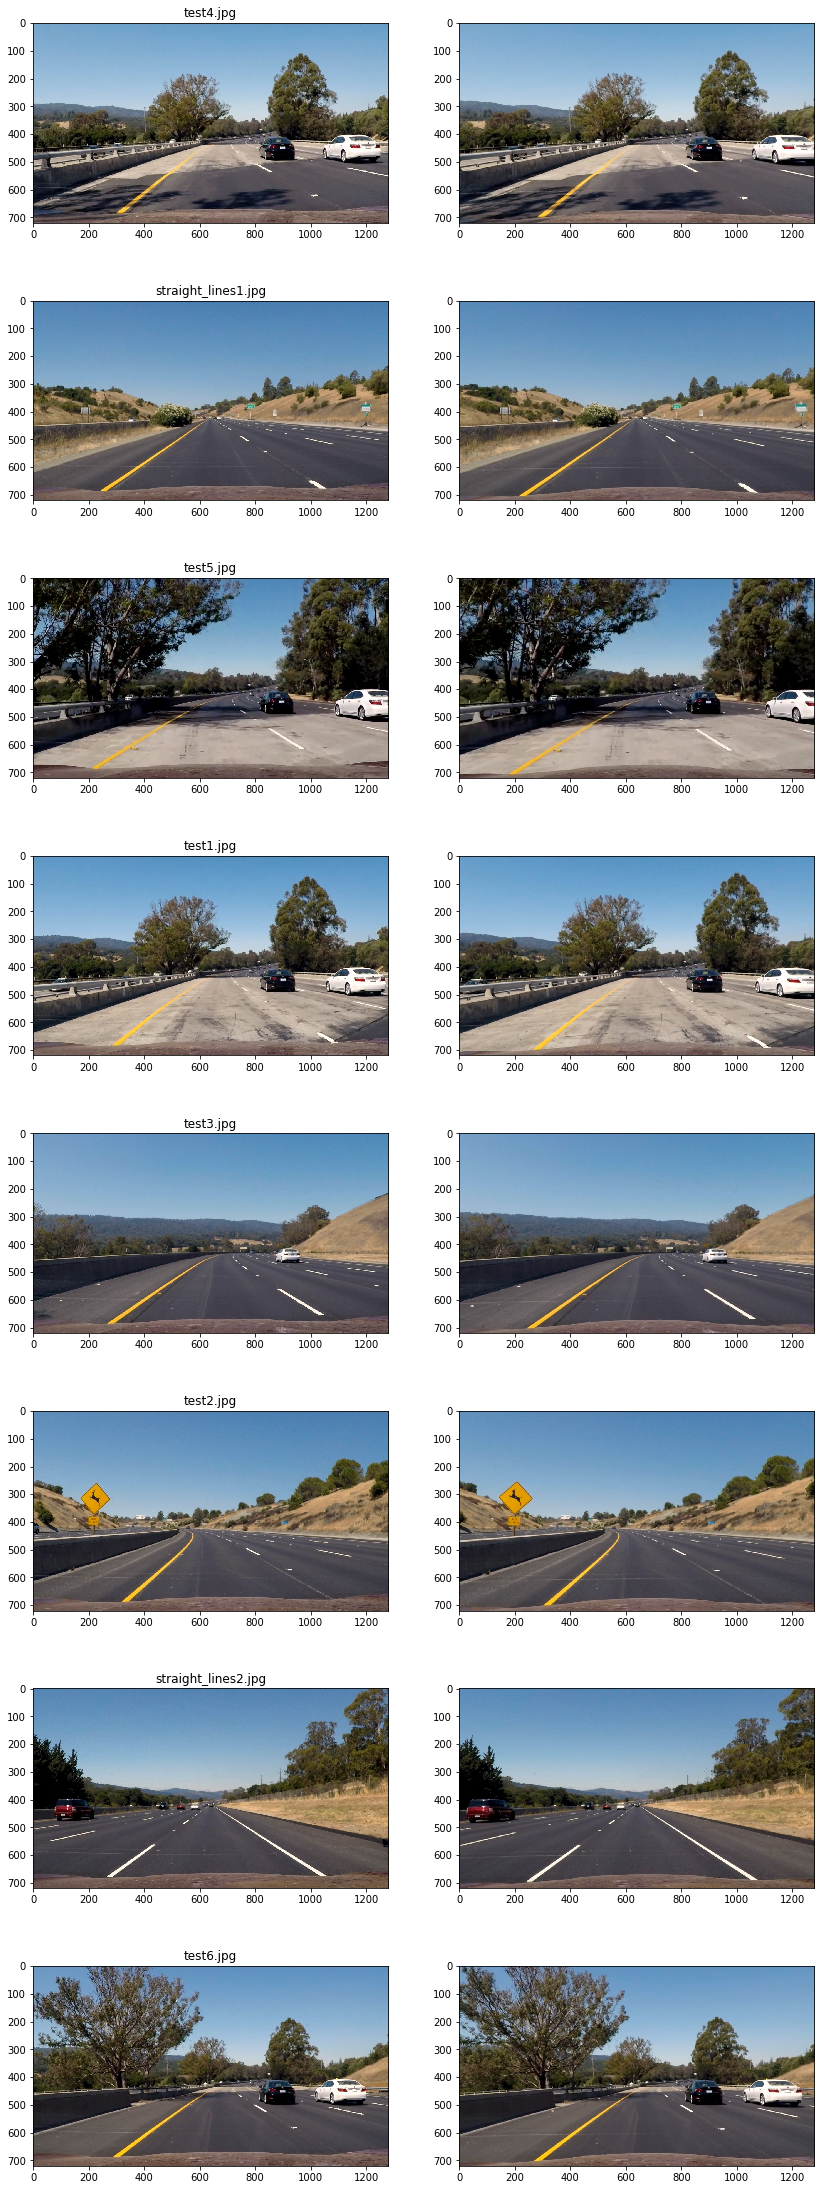

In [4]:
test_imgs_paths = glob.glob("test_images/*.jpg")
fig, ax = plt.subplots(len(test_imgs_paths), 2, figsize=(14, 5*len(test_imgs_paths)))
i = 0
for img_path in test_imgs_paths:
    img = mpimg.imread(img_path)
    ax[i, 0].imshow(img)
    ax[i, 0].set_title(img_path[12:])
    undist_img = undistort(img, mtx, dist)
    ax[i, 1].imshow(undist_img)
    #mpimg.imsave("output_images/undistorted_" + img_path[12:-4] + ".jpg", undist_img)
    i+=1
plt.show()

## Use color transforms, gradients, etc., to create a thresholded binary image

### HLS and Color Thresholds

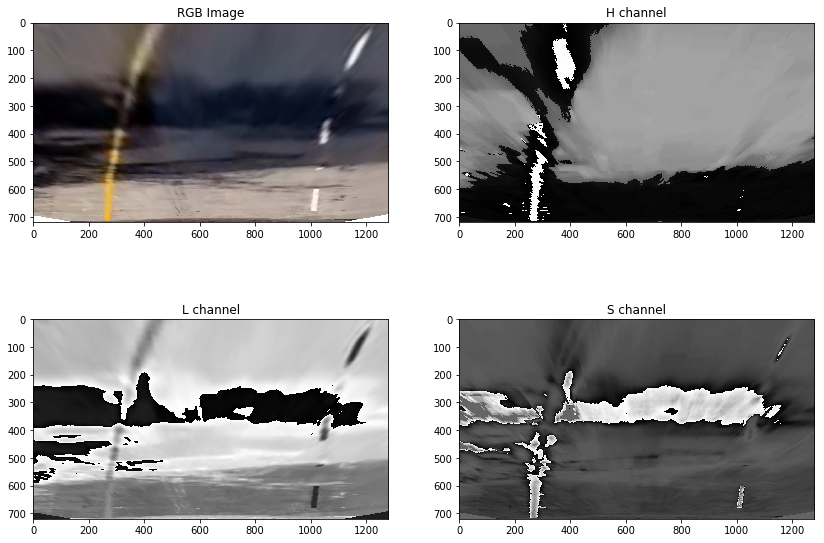

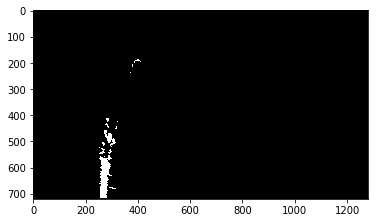

In [5]:
def hls_analysis(rgb_img, test=True):
    hls_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    h = hls_img[:,:,0]
    l = hls_img[:,:,1]
    s = hls_img[:,:,2]
    """
    # Param for white line
    h_thr = (0, 255)
    l_thr = (210, 255)
    s_thr = (0, 255)
    """    
    # Param for yellow line
    h_thr = (18, 30)
    l_thr = (30, 204)
    s_thr = (100, 255)

    h[(h < h_thr[0]) & (h_thr[1] < h)] = 0 
    h = (h - h_thr[0]) * 255 /(h_thr[1]-h_thr[0])
    l[(l < l_thr[0]) & (l_thr[1] < l)] = 0 
    l = (l - l_thr[0]) * 255 /(l_thr[1]-l_thr[0])
    s[(s < s_thr[0]) & (s_thr[1] < s)] = 0 
    s = (s - s_thr[0]) * 255 /(s_thr[1]-s_thr[0])
    
    hls_bin = np.zeros_like(hls_img[:,:,0])
    hls_bin[((h_thr[0] <= hls_img[:,:,0]) & (hls_img[:,:,0] <= h_thr[1]))          # Hue range for yellow line
            & ((l_thr[0] <= hls_img[:,:,1]) & (hls_img[:,:,1] <= l_thr[1]))       # Lightness for yellow line
            & ((s_thr[0] <= hls_img[:,:,2]) & (hls_img[:,:,2] <= s_thr[1]))] = 1 # Saturation half and above for yellow
    
    if test:
        fig, ax = plt.subplots(2, 2, figsize=(14, 10))
        ax[0, 0].imshow(rgb_img)
        ax[0, 0].set_title("RGB Image")
        ax[0, 1].imshow(h, cmap='gray')
        ax[0, 1].set_title("H channel")
        ax[1, 0].imshow(l, cmap='gray')
        ax[1, 0].set_title("L channel")
        ax[1, 1].imshow(s, cmap='gray')
        ax[1, 1].set_title("S channel")
        plt.show()

    return hls_bin

hls_bin = hls_analysis(mpimg.imread("output_images/warped_test5.jpg"))
plt.imshow(hls_bin, cmap='gray')

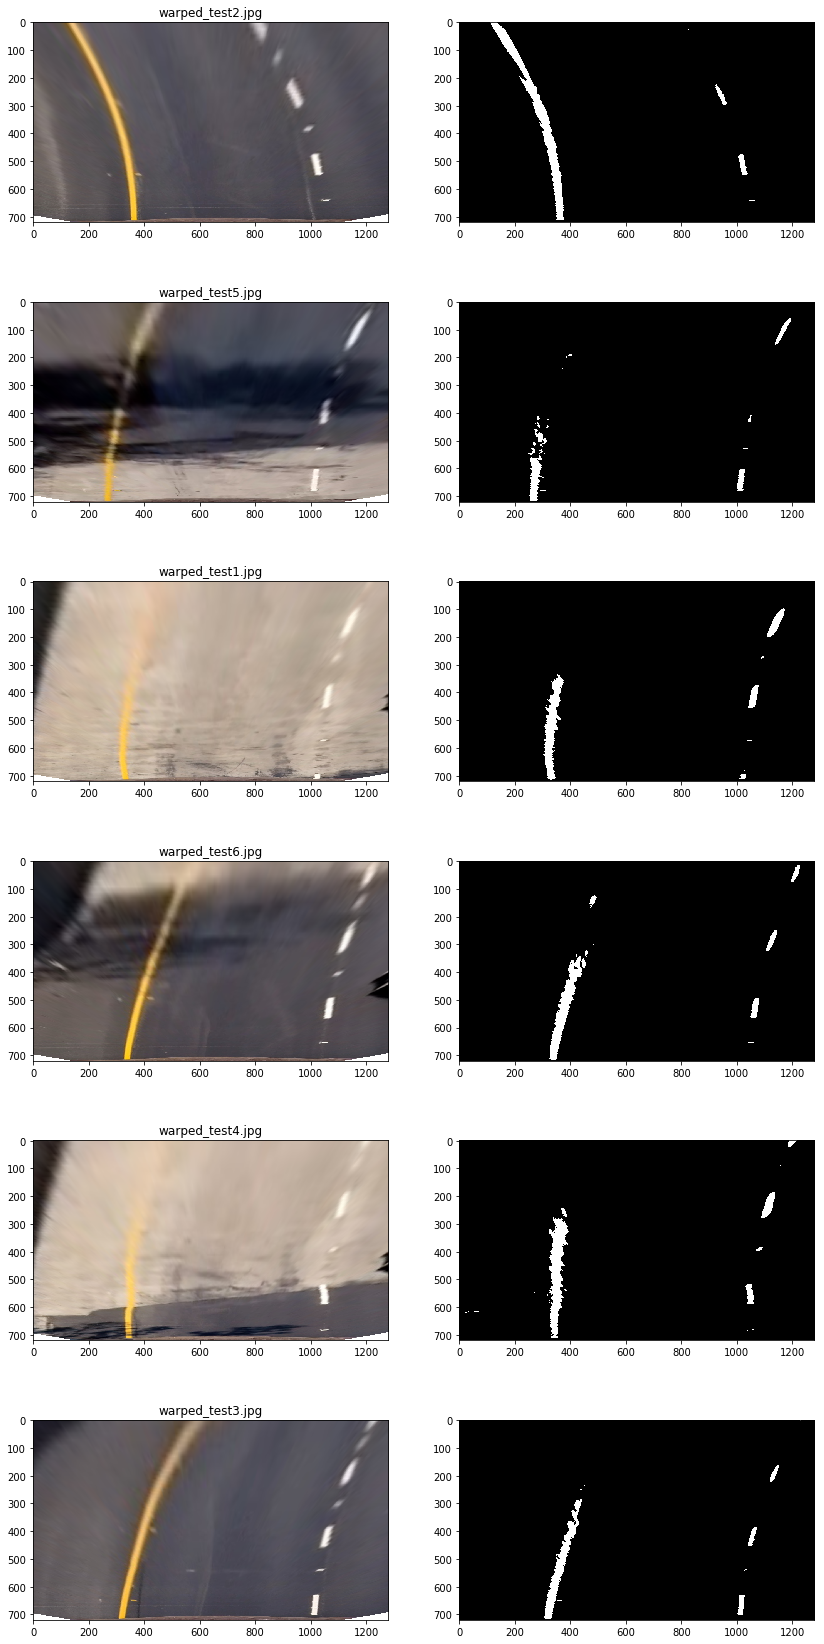

In [6]:
def hls_binary(rgb_img, h_thr=(18,30), l_thr=(30,204), s_thr=(100,255), wl_thr=(210,255), test=False):
    hls_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    hls_bin = np.zeros_like(hls_img[:,:,0])
    hls_bin[((h_thr[0] <= hls_img[:,:,0]) & (hls_img[:,:,0] <= h_thr[1]))    # Hue range for yellow line
            & ((l_thr[0] <= hls_img[:,:,1]) & (hls_img[:,:,1] <= l_thr[1]))  # Lightness for yellow line
            & ((s_thr[0] <= hls_img[:,:,2]) & (hls_img[:,:,2] <= s_thr[1]))  # Saturation half and above for yellow
            | ((wl_thr[0] <= hls_img[:,:,1]) & (hls_img[:,:,1] <= wl_thr[1]))] = 1 # High lightness for whaite line
    if test:
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        ax[0].imshow(rgb_img)
        ax[0].set_title("RGB Image")
        ax[1].imshow(hls_bin, cmap='gray')
        ax[1].set_title("HLS Binary Image")
        plt.show()
    return hls_bin

#hls_bin = hls_binary(mpimg.imread("output_images/undistorted_test6.jpg"), True)

test_imgs_paths = glob.glob("output_images/warped_test*.jpg")
fig, ax = plt.subplots(len(test_imgs_paths), 2, figsize=(14, 5*len(test_imgs_paths)))
i = 0
for img_path in test_imgs_paths:
    img = mpimg.imread(img_path)
    ax[i, 0].set_title(img_path[14:])
    ax[i, 0].imshow(img)
    hls_bin = hls_binary(img)
    ax[i, 1].imshow(hls_bin*255, cmap='gray')
    i+=1
plt.show()


# Gradient Thresholds

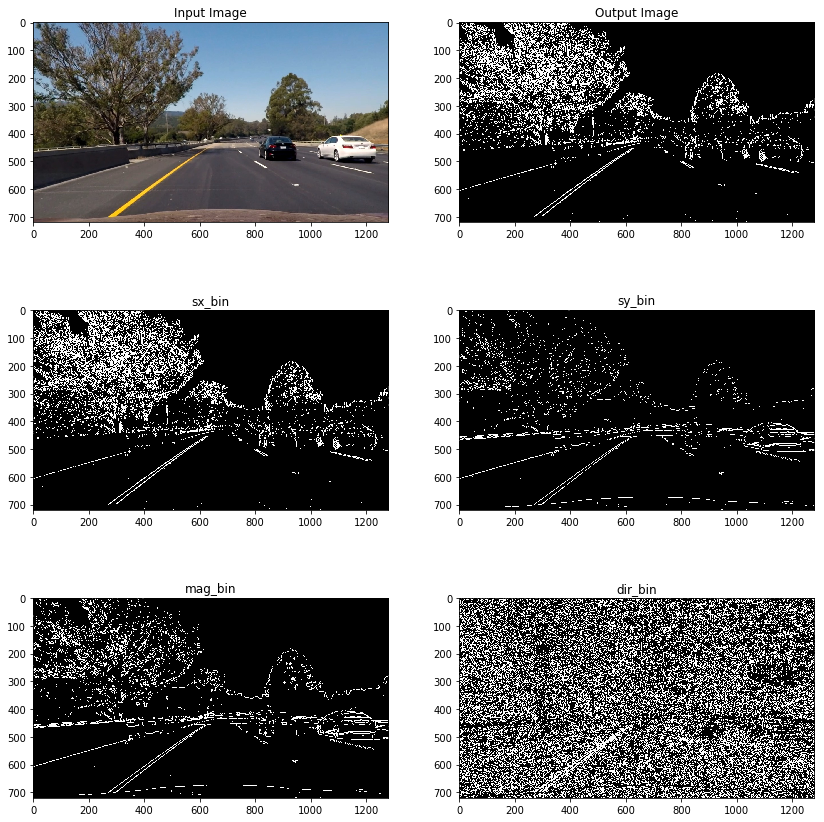

In [7]:
def gradient_binary(rgb_img, sx=(20, 120), sy=(50, 150), mag=(50, 150), ang=(.7, 1.3), kernel_size=15, test=False):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, kernel_size)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    # 5) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    sx_bin = np.zeros_like(scaled_sobelx)
    sx_bin[(sx[0] <= scaled_sobelx) & (scaled_sobelx <= sx[1])] = 1
    sy_bin = np.zeros_like(scaled_sobely)
    sy_bin[(sy[0] <= scaled_sobely) & (scaled_sobely <= sy[1])] = 1
    
    # 6) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 7) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 8) Create a binary mask where mag thresholds are met
    mag_bin = np.zeros_like(scaled_sobelxy)
    mag_bin[(mag[0] <= scaled_sobelxy) & (scaled_sobelxy <= mag[1])] = 1
    
    # 9) Take the absolute value of the gradient direction, apply a threshold, and create a binary image result
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    dir_bin = np.zeros_like(absgraddir)
    dir_bin[(ang[0] <= absgraddir) & (absgraddir <= ang[1])] = 1
    
    # 10) Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined = np.zeros_like(absgraddir)
    combined[(sx_bin == 1) | ((sy_bin == 1) & (mag_bin == 1) & (dir_bin == 1))] = 1
    
    if test:
        fig, ax = plt.subplots(3, 2, figsize=(14, 5*3))
        ax[0, 0].imshow(rgb_img)
        ax[0, 0].set_title("Input Image")
        ax[0, 1].imshow(combined, cmap='gray')
        ax[0, 1].set_title("Output Image")
        ax[1, 0].imshow(sx_bin, cmap='gray')
        ax[1, 0].set_title("sx_bin")
        ax[1, 1].imshow(sy_bin, cmap='gray')
        ax[1, 1].set_title("sy_bin")
        ax[2, 0].imshow(mag_bin, cmap='gray')
        ax[2, 0].set_title("mag_bin")
        ax[2, 1].imshow(dir_bin, cmap='gray')
        ax[2, 1].set_title("dir_bin")
        plt.show()
    return combined

grad_bin = gradient_binary(mpimg.imread("output_images/undistorted_test6.jpg"), sx=(20, 120), sy=(50, 150), mag=(50, 150), ang=(.7, 1.3), kernel_size=15, test=True)

### Combining HLS and Gradient Thresholds

In [ ]:
def combined_binary(img, test=False):
    hls_bin = hls_binary(img)
    grad_bin = gradient_binary(img)
    combined_binary = np.zeros_like(hls_bin)
    combined_binary[(hls_bin == 1) | (grad_bin == 1)] = 1
    
    if test:
        color_binary = np.dstack((hls_bin, grad_bin, np.zeros_like(hls_bin))) * 255
        color_binary = color_binary.astype(np.uint8)
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        ax[0].imshow(color_binary)
        ax[0].set_title("Stacked Thresholds: R:HLS; G:grad")
        ax[1].imshow(combined_binary, cmap='gray')
        ax[1].set_title("Combined Color And Gradient Thresholds")
        #mpimg.imsave("output_images/color_binary.jpg", color_binary)
        plt.show()
    return combined_binary

combined_bin = combined_binary(mpimg.imread("output_images/undistorted_test6.jpg"), True)

## Apply a perspective transform to rectify binary image ("birds-eye view")

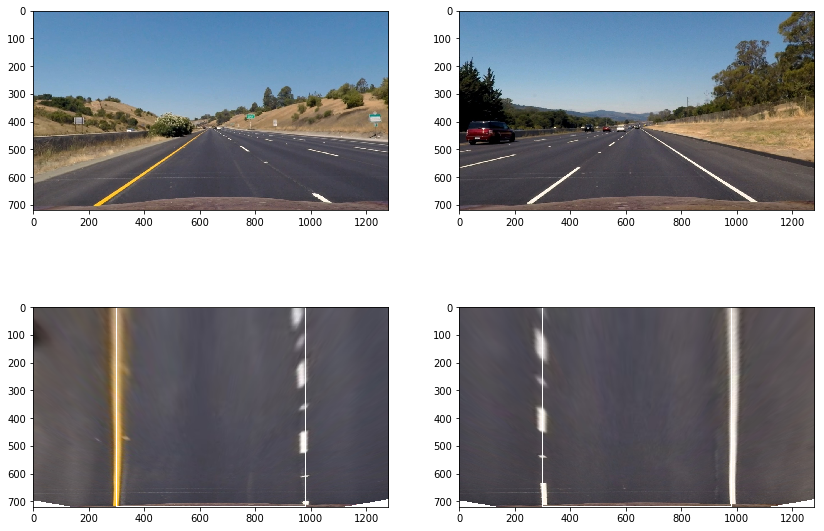

In [9]:
def perspective_transform_matrices(test=False):
    # Givend the shape size manually
    (bottom_px, right_px) = (720 - 1, 1280 - 1)
    # Arbitrary given the left and right points
    (left_btm, right_btm) = (210, 1100)
    #mid = (right_btm + left_btm) // 2
    mid = 642 # 642 for best transform the lane into parallel lines. The camera might not been mounted in the center of car.
    (left_top, right_top) = (mid-(right_btm - left_btm)//19, mid+(right_btm - left_btm)//19)
    #src_pts = np.array([[210,719],[596,450],[688,450], [1100, 719]], np.float32)
    src_pts = np.array([[left_btm,bottom_px],[left_top,450],[right_top,450], [right_btm, bottom_px]], np.float32)
    margin = 300
    #dst_pts = np.array([[300,719],[300,0],[979,0], [979, 719]], np.float32)
    dst_pts = np.array([[margin, bottom_px], [margin, 0], [right_px-margin, 0], [right_px-margin, bottom_px]], np.float32)
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    M_inv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    if test:
        img1 = mpimg.imread("output_images/undistorted_straight_lines1.jpg")
        img2 = mpimg.imread("output_images/undistorted_straight_lines2.jpg")
        src_pts = src_pts.astype(np.int32)
        dst_pts = dst_pts.astype(np.int32)
        #cv2.line(img1, (mid, bottom_px), (mid, 0), (1,0,0), 3)
        #cv2.line(img2, (mid, bottom_px), (mid, 0), (1,0,0), 3)
        #cv2.polylines(img1, [src_pts], True, (100,0,0), 3)
        #cv2.polylines(img2, [src_pts], True, (200,0,0), 3)
        warped1 = cv2.warpPerspective(img1, M, img1.shape[1::-1], flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255,0,0,0))
        warped2 = cv2.warpPerspective(img2, M, img2.shape[1::-1], flags=cv2.INTER_LINEAR)
        #cv2.line(warped1, (mid, bottom_px), (mid, 0), (1,0,0), 3)
        #cv2.line(warped2, (mid, bottom_px), (mid, 0), (1,0,0), 3)
        cv2.polylines(warped1, [dst_pts], True, (100,0,0), 3)
        cv2.polylines(warped2, [dst_pts], True, (200,0,0), 3)

        fig, ax = plt.subplots(2, 2, figsize=(14, 10))
        ax[0, 0].imshow(img1)
        ax[0, 1].imshow(img2)
        ax[1, 0].imshow(warped1)
        ax[1, 1].imshow(warped2)
        plt.show()
    return (M, M_inv)
(M, M_inv) = perspective_transform_matrices(True)

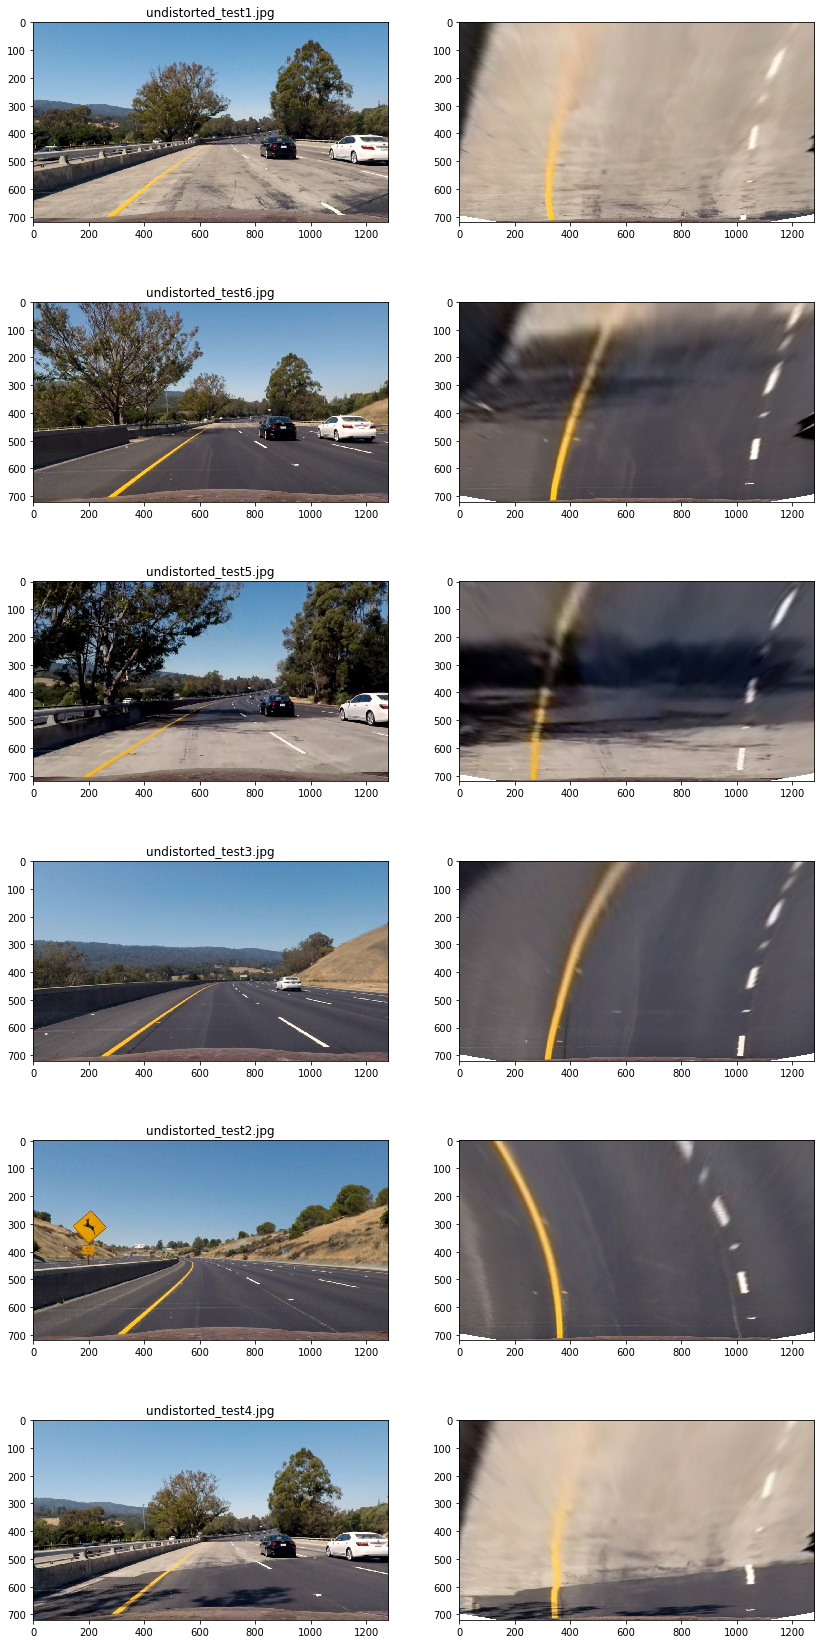

In [10]:
test_imgs_paths = glob.glob("output_images/undistorted_test*.jpg")
fig, ax = plt.subplots(len(test_imgs_paths), 2, figsize=(14, 5*len(test_imgs_paths)))
i = 0
for img_path in test_imgs_paths:
    img = mpimg.imread(img_path)
    warped_img = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    #inv_img = cv2.warpPerspective(warped_img, M_inv, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    ax[i, 0].imshow(img)
    ax[i, 0].set_title(img_path[14:])
    #ax[i, 0].imshow(inv_img)
    ax[i, 1].imshow(warped_img)
    #mpimg.imsave("output_images/warped_" + img_path[26:-4] + ".jpg", warped_img)
    i+=1
plt.show()

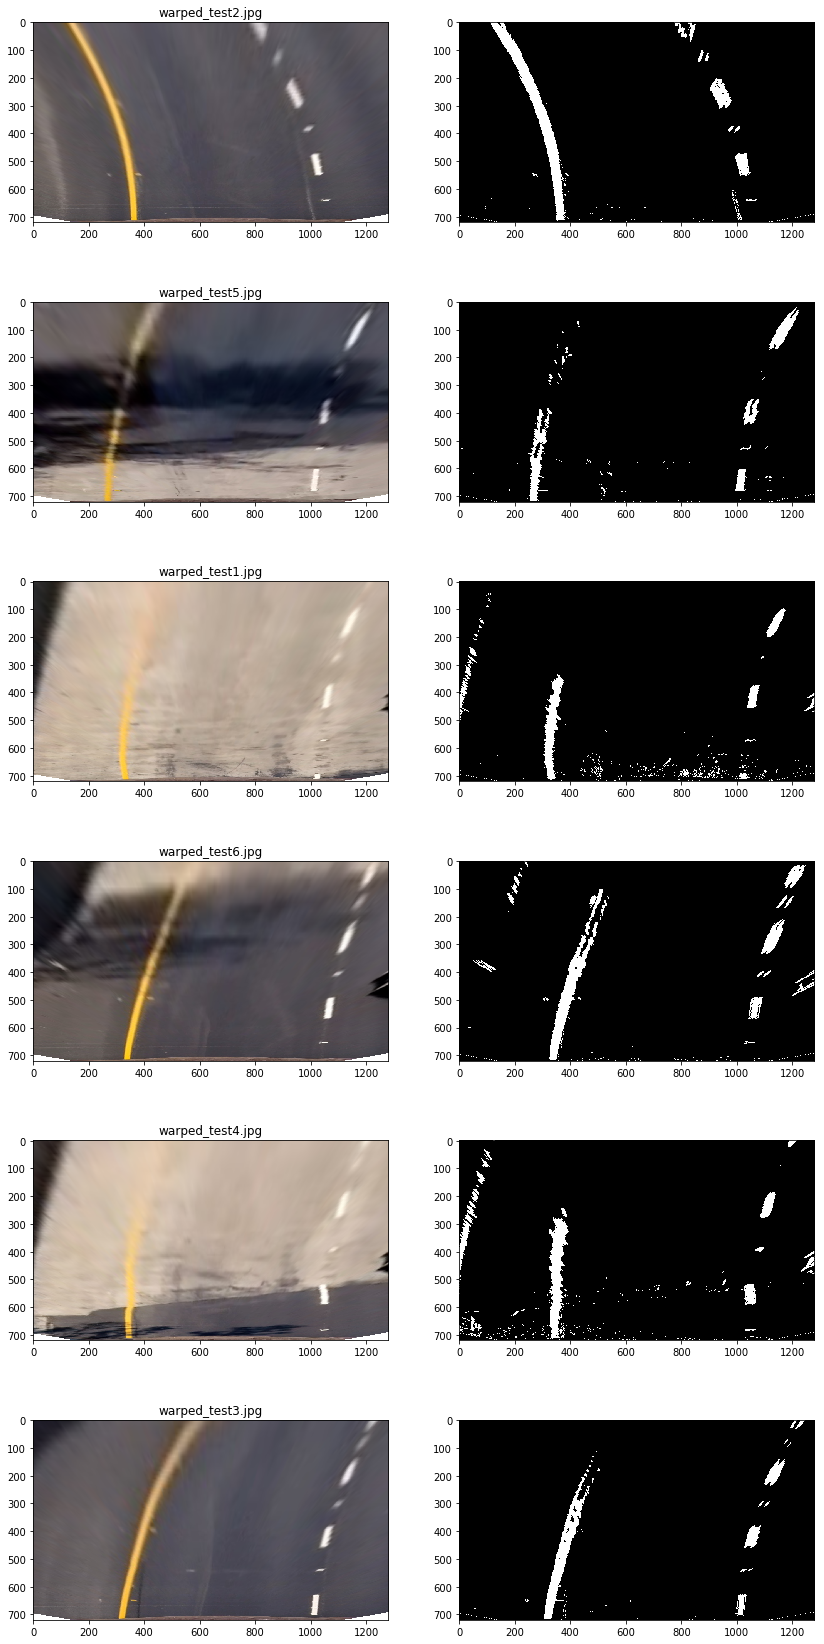

In [16]:
test_imgs_paths = glob.glob("output_images/warped_test*.jpg")
fig, ax = plt.subplots(len(test_imgs_paths), 2, figsize=(14, 5*len(test_imgs_paths)))
i = 0
combined_bin = []
for img_path in test_imgs_paths:
    img = mpimg.imread(img_path)
    ax[i, 0].imshow(img)
    ax[i, 0].set_title(img_path[14:])
    combined_bin.append( combined_binary(img) )
    ax[i, 1].imshow(combined_bin[i], cmap='gray')
    i+=1
plt.show()

## Detect lane pixels and fit to find the lane boundary

In [17]:
class LaneLine:
    def __init__(self):
        
        self.poly_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [18]:
"""
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    return histogram

fig, ax = plt.subplots(len(combined_bin), 2, figsize=(14, 30))
i = 0
for img in combined_bin:
    ax[i, 0].imshow(img, cmap='gray')
    ax[i, 1].plot(hist(img))
    i+=1
plt.show()
"""

"\ndef hist(img):\n    # TO-DO: Grab only the bottom half of the image\n    # Lane lines are likely to be mostly vertical nearest to the car\n    bottom_half = img[img.shape[0]//2:,:]\n    # TO-DO: Sum across image pixels vertically - make sure to set `axis`\n    # i.e. the highest areas of vertical lines should be larger values\n    histogram = np.sum(bottom_half, axis=0)\n    return histogram\n\nfig, ax = plt.subplots(len(combined_bin), 2, figsize=(14, 30))\ni = 0\nfor img in combined_bin:\n    ax[i, 0].imshow(img, cmap='gray')\n    ax[i, 1].plot(hist(img))\n    i+=1\nplt.show()\n"

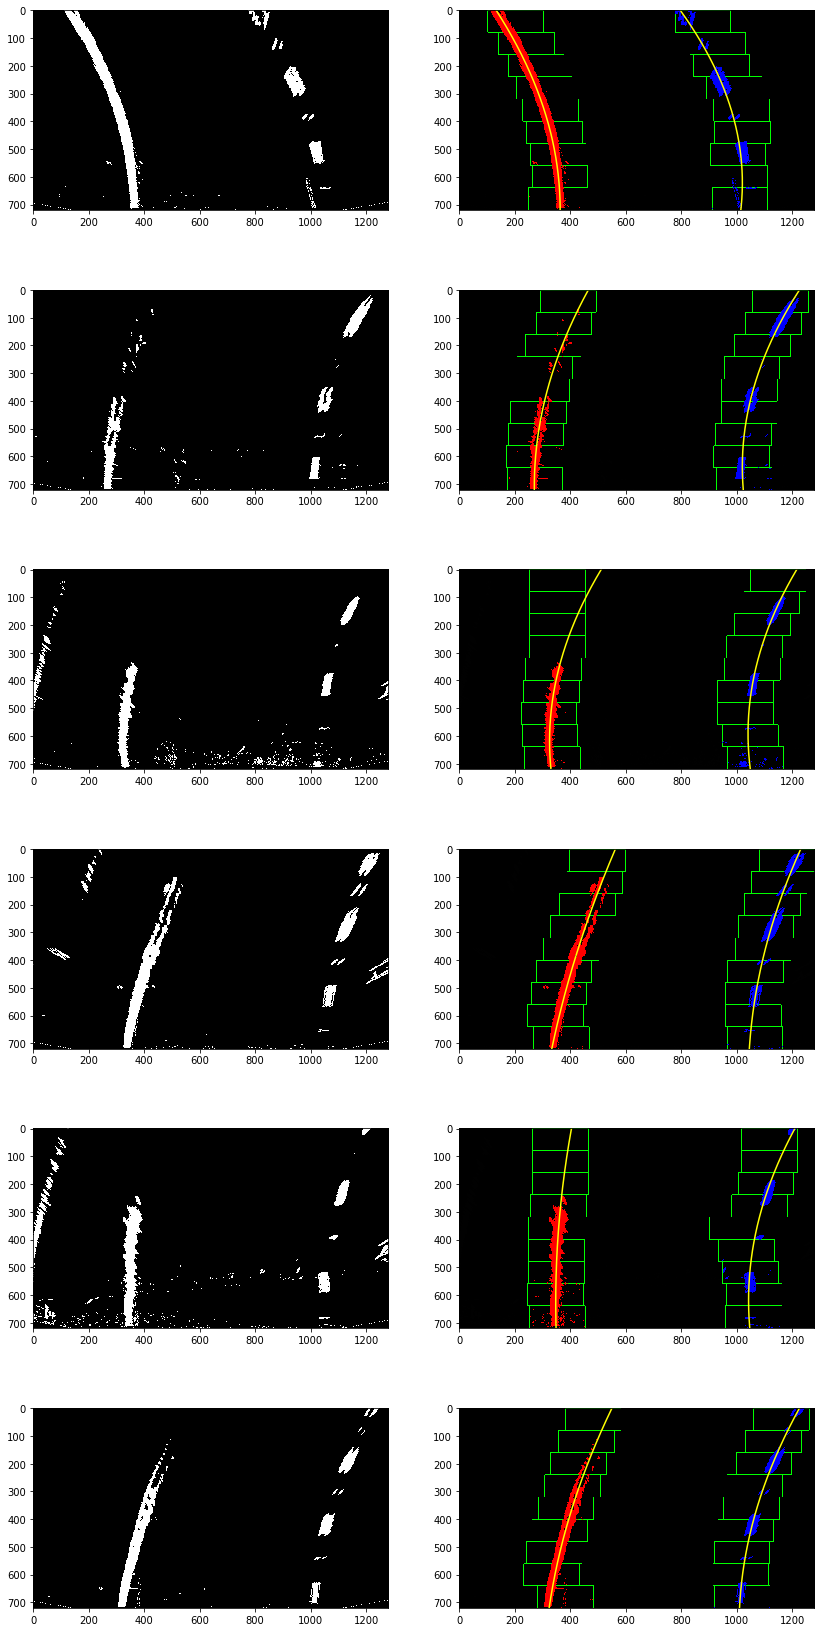

In [19]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return (img, left_fitx, right_fitx, ploty, out_img)

fig, ax = plt.subplots(len(combined_bin), 2, figsize=(14, 30))
i = 0
img_data = []
for img in combined_bin:
    ax[i, 0].imshow(img, cmap='gray')
    img_data.append(fit_polynomial(img))
    ax[i, 1].imshow(img_data[i][4])
    ax[i, 1].plot(img_data[i][1], img_data[i][3], color='yellow')
    ax[i, 1].plot(img_data[i][2], img_data[i][3], color='yellow')
    i+=1
plt.show()

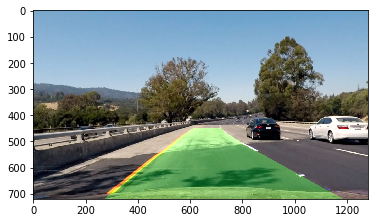

In [20]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def compute_lane_lines(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 23

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Packing data into LaneLine structue
    left_line = LaneLine()
    right_line = LaneLine()
    left_line.poly_coeff = left_fit
    left_line.line_fit_x = left_fitx
    left_line.non_zero_x = leftx
    left_line.non_zero_y = lefty
    right_line.poly_coeff = right_fit
    right_line.line_fit_x = right_fitx
    right_line.non_zero_x = rightx
    right_line.non_zero_y = righty
    
    return left_line, right_line
    
def draw_lane_area(binary_warped, left_line, right_line, undist_img, test=False):
    left_fitx = left_line.line_fit_x
    leftx = left_line.non_zero_x
    lefty = left_line.non_zero_y
    right_fitx = right_line.line_fit_x
    rightx = right_line.non_zero_x
    righty = right_line.non_zero_y
    margin = 23
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))#*255 # Leave the binary image (1,1,1) if not color by lane inds below

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #warped_lane = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    warped_lane = out_img
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warped_lane, np.int_([pts]), (0,255, 0))
    ## End Warped lane drawing steps ##
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warped_lane, M_inv, undist_img.shape[1::-1], flags=cv2.INTER_LINEAR) 

    # Combine the result with the original image
    if (undist_img.shape[2]==4): 
        if test: print(undist_img.shape[:]," : ", newwarp.shape[:])
        undist_img = cv2.cvtColor(undist_img, cv2.COLOR_RGBA2RGB)
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    ## End visualization steps ##
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
ll, rl = compute_lane_lines(combined_bin[4])
result = draw_lane_area(combined_bin[4], ll, rl, mpimg.imread("output_images/undistorted_test4.jpg"))
plt.imshow(result)

## Determine the curvature of the lane and vehicle position with respect to center

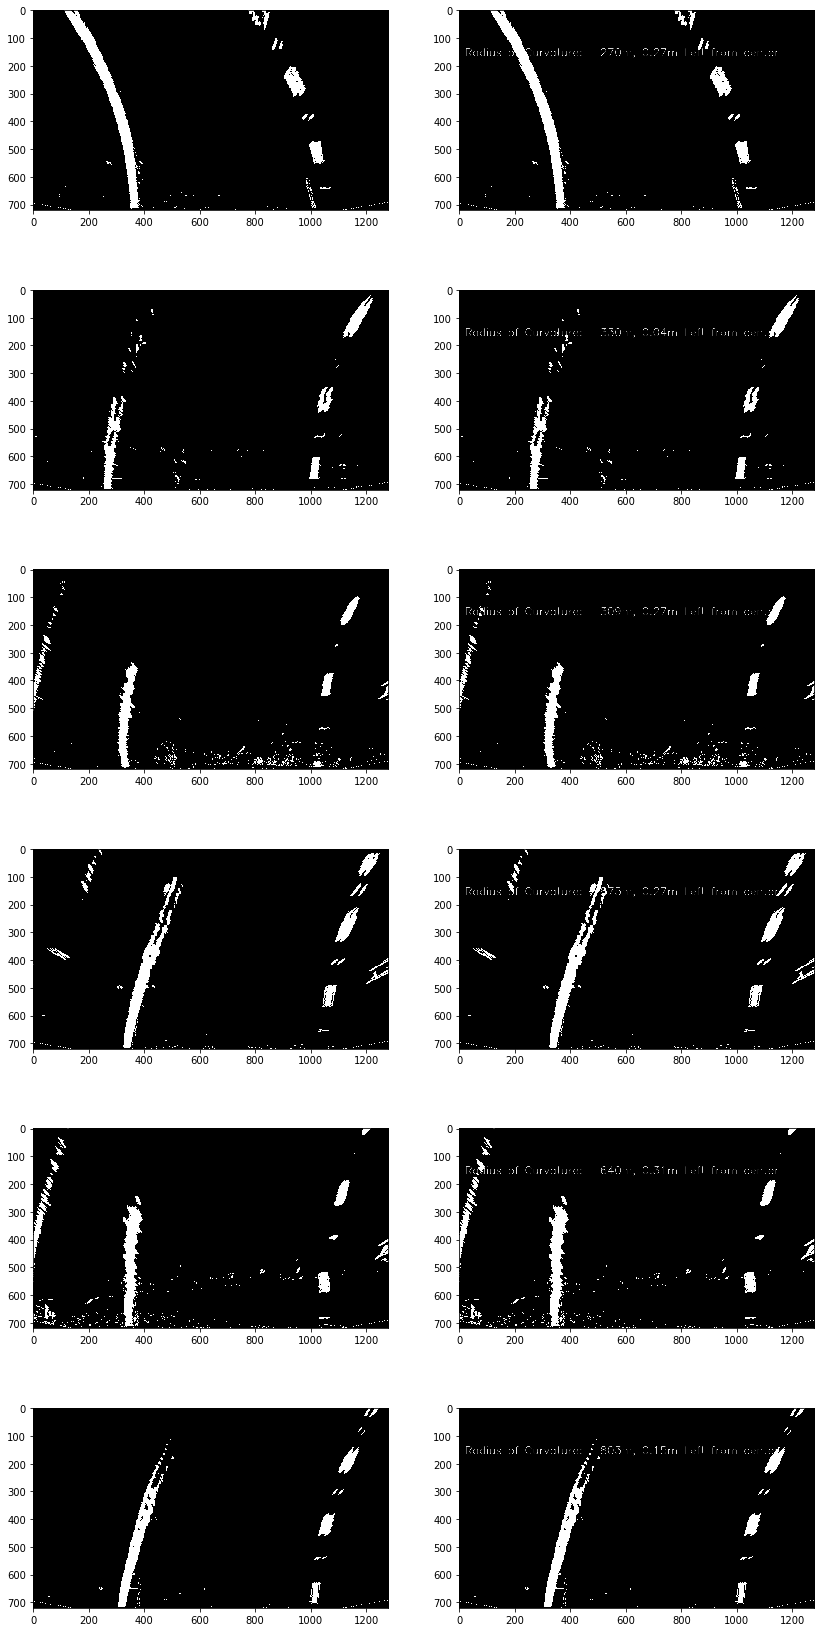

In [21]:
def compute_cur(left_line, right_line):
    left_fit = left_line.poly_coeff
    left_fitx = left_line.line_fit_x
    #leftx = left_line.non_zero_x
    #lefty = left_line.non_zero_y
    right_fit = right_line.poly_coeff
    right_fitx = right_line.line_fit_x
    #rightx = right_line.non_zero_x
    #righty = right_line.non_zero_y
    # Generate x and y values for plotting
    ploty = np.linspace(0, 720-1, 720)
    
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = 30/720 # meters per pixel in y dimension #32/720
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension #3.7/800
    ym_per_pix = 28.5/720 # real_world_lane_size_meters[0] / self.img_dimensions[0] #25.68/720
    xm_per_pix = 3.7/680 # real_world_lane_size_meters[1] / self.lane_width_px #(680=980-300) (980=1280-300)
    lane_center_px = 640 # (center of 300 and 980)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    center_offset_px = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + 
                   (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - lane_center_px
    center_offset_m = center_offset_px * xm_per_pix

    return left_curverad, right_curverad, center_offset_m

def draw_lane_curvature_text(rgb_img, left_curvature_meters, right_curvature_meters, center_offset_meters, test=False):
    if (rgb_img.shape[:]==(720, 1280)): 
        if test: print(rgb_img.shape[:])
        bin_img = rgb_img
        rgb_img = np.dstack((bin_img, bin_img, bin_img))*255
    """
    Returns an image with curvature information inscribed
    """
    offset_y = 165
    offset_x = 20
    avrg = (left_curvature_meters+right_curvature_meters)//2
    
    text = "Radius of Curvature: {:5d}m".format(int(avrg))+", {:.2f}m Left from center".format(center_offset_meters)
    if center_offset_meters < 0.0:
        text = "Radius of Curvature: {:5d}m".format(int(avrg))+", {:.2f}m Right from center".format(math.fabs(center_offset_meters))

    if test: print(text)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(rgb_img, text, (offset_x, offset_y), font, 1.3, (255,255,255), 1, cv2.LINE_AA)
    
    return rgb_img

fig, ax = plt.subplots(len(combined_bin), 2, figsize=(14, 5*len(combined_bin)))
i = 0
for img in combined_bin:
    ax[i, 0].imshow(img*255, cmap='gray')
    ll, rl = compute_lane_lines(img)
    lcr, rcr, com = compute_cur(ll, rl)
    ax[i, 1].imshow(draw_lane_curvature_text(img, lcr, rcr, com))
    i+=1
plt.show()

## Warp the detected lane boundaries back onto the original image
## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

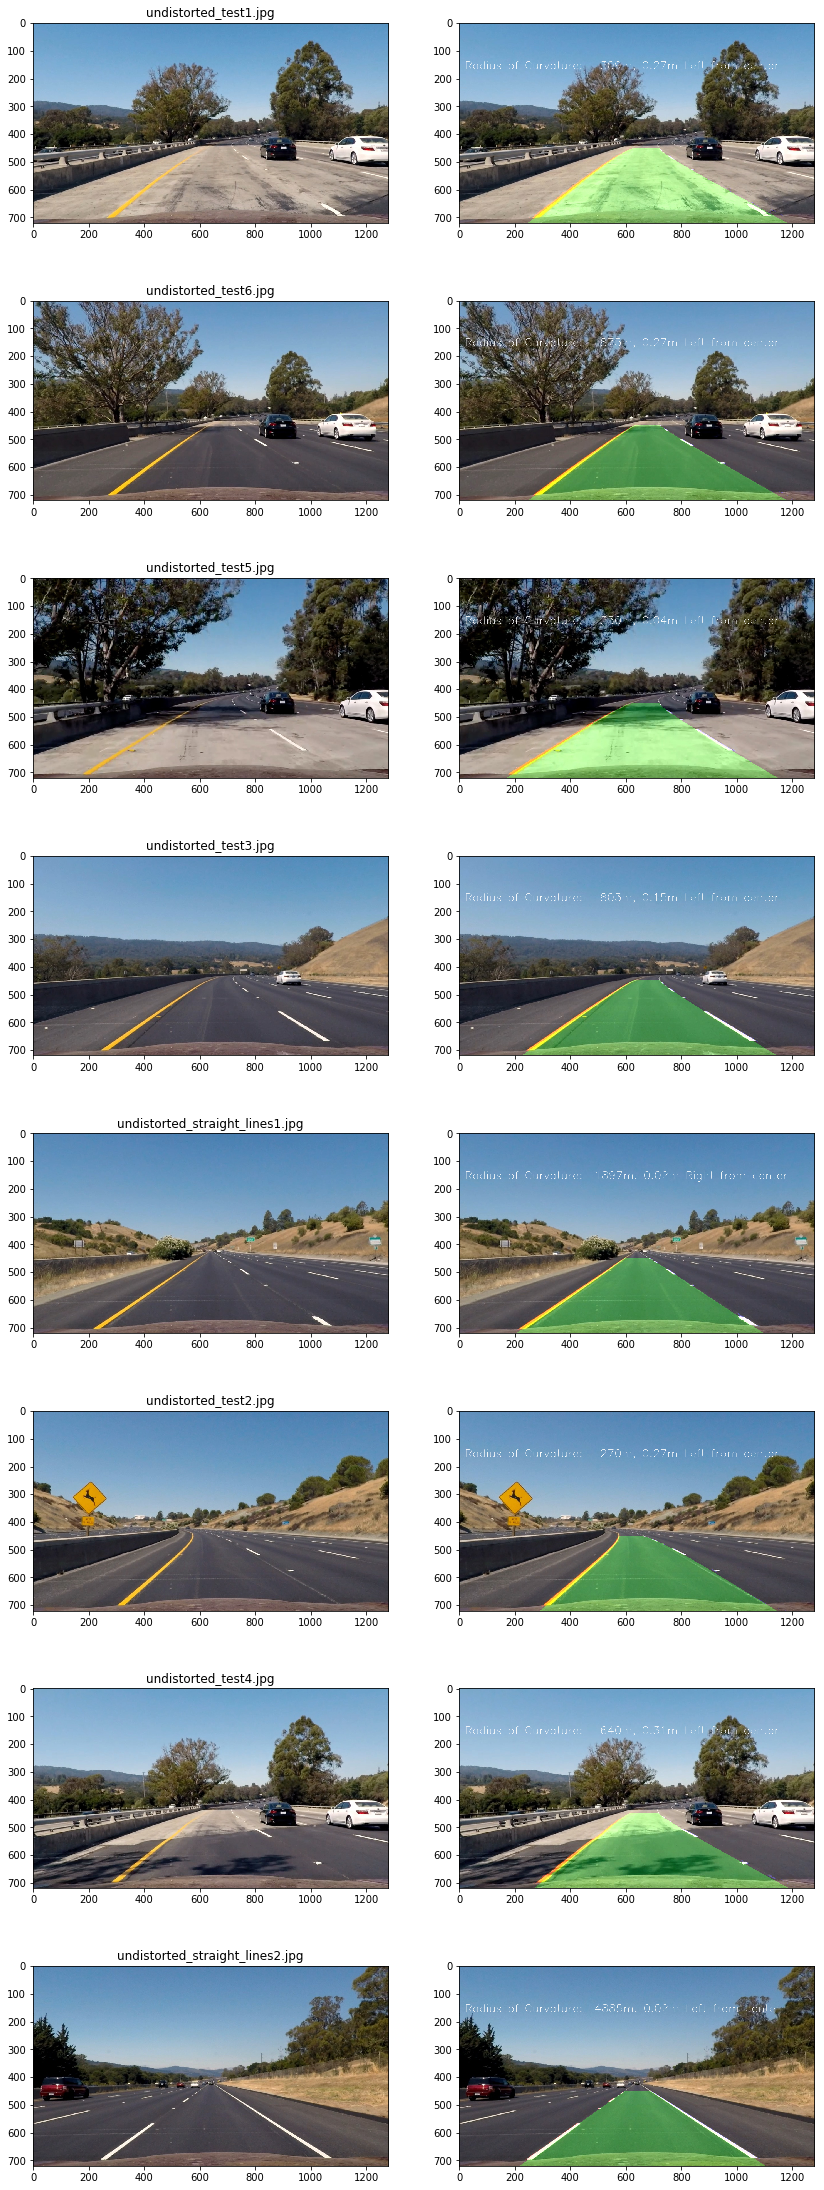

In [23]:
def process_undist_image(undist_img):
    warped_img = cv2.warpPerspective(undist_img, M, undist_img.shape[1::-1], flags=cv2.INTER_LINEAR)
    bin_img = combined_binary(warped_img)
    ll, rl = compute_lane_lines(bin_img)
    lcr, rcr, com = compute_cur(ll, rl)
    lane_img = draw_lane_area(bin_img, ll, rl, undist_img)
    final_img = draw_lane_curvature_text(lane_img, lcr, rcr, com)
    return final_img
    
test_imgs_paths = glob.glob("output_images/undistorted_*.jpg")
fig, ax = plt.subplots(len(test_imgs_paths), 2, figsize=(14, 5*len(test_imgs_paths)))
i = 0
for img_path in test_imgs_paths:
    undist_img = mpimg.imread(img_path)
    final_img = process_undist_image(undist_img)
    ax[i, 0].imshow(undist_img)
    ax[i, 0].set_title(img_path[14:])
    ax[i, 1].imshow(final_img)
    #mpimg.imsave("output_images/final_" + img_path[26:] , final_img)
    i+=1
plt.show()

## Import Packages for Videos

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
mtx, dist = load_obj_img_pts()
(M, M_inv) = perspective_transform_matrices()
def process_image(dist_img):
    undist_img = undistort(dist_img, mtx, dist)
    warped_img = cv2.warpPerspective(undist_img, M, undist_img.shape[1::-1], flags=cv2.INTER_LINEAR)
    bin_img = combined_binary(warped_img)
    ll, rl = compute_lane_lines(bin_img)
    lcr, rcr, com = compute_cur(ll, rl)
    lane_img = draw_lane_area(bin_img, ll, rl, undist_img)
    final_img = draw_lane_curvature_text(lane_img, lcr, rcr, com)
    return final_img

In [22]:
name = "project_video.mp4"
output_path = "output_videos/"
clip1 = VideoFileClip(name)#.subclip(13,14)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path+name, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [07:01<00:00,  2.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 4min 47s, sys: 3 s, total: 4min 50s
Wall time: 7min 4s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path+name))

In [28]:
name = "challenge_video.mp4"
output_path = "output_videos/"
clip1 = VideoFileClip(name)#.subclip(13,14)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path+name, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [02:45<00:00,  2.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 1min 42s, sys: 15.9 s, total: 1min 58s
Wall time: 2min 48s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos/challenge_video.mp4"))

In [60]:
name = "harder_challenge_video.mp4"
output_path = "output_videos/"
clip1 = VideoFileClip(name)#.subclip(13,14)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path+name, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [08:25<00:00,  2.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

CPU times: user 4min 56s, sys: 42.9 s, total: 5min 39s
Wall time: 8min 29s


In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path+name))